In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import Sequential
from tensorflow.contrib.eager.python import tfe
from tensorflow.keras import initializers
from tensorflow.keras.layers import Dense, LeakyReLU, Reshape, BatchNormalization,\
Conv2DTranspose, Conv2D, Flatten, Dropout, ReLU
from tensorflow.keras import backend as K
from keras.engine import InputSpec
import os

/home/mattmann/install/python37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/mattmann/install/python37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/mattmann/install/python37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/mattmann/install/python37/lib/python3.7/site-pack

In [2]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
tf.enable_eager_execution(config=config)

In [3]:
downsize_factor = 2
scale_factor = 4 ** downsize_factor
noise_dim = 128
weight_init_std = 0.02
weight_init_mean = 0.0
leaky_relu_slope = 0.2
image_width = 64
image_height = 64
image_channels = 3
dropout_rate = 0.5
lr_initial_g = tfe.Variable(0.0002)
lr_initial_d = tfe.Variable(0.0002)

In [4]:
weight_initializer = tf.keras.initializers.TruncatedNormal(stddev=weight_init_std, mean=weight_init_mean,
                                                          seed=42)

In [5]:
generator_optimizer = tf.train.AdamOptimizer(learning_rate=lr_initial_g, beta1=0.5)

In [6]:
discriminator_optimizer = tf.train.AdamOptimizer(learning_rate=lr_initial_d, beta1=0.5)

In [7]:
def convSN(model, out_channels, ksize, stride_size):
    model.add(ConvSN2D(out_channels, (ksize, ksize), strides=(stride_size, stride_size), padding='same',
                     kernel_initializer=weight_initializer, use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=leaky_relu_slope))
    return model

In [8]:
def transposed_conv(model, out_channels, ksize, stride_size, ptype='same'):
    model.add(Conv2DTranspose(out_channels, (ksize, ksize),
                              strides=(stride_size, stride_size), padding=ptype, 
                              kernel_initializer=weight_initializer, use_bias=False))
    model.add(BatchNormalization())
    model.add(ReLU())
    return model

In [9]:
class DenseSN(Dense):
    def build(self, input_shape):
        assert len(input_shape) >= 2
        input_dim = input_shape[-1]
        self.kernel = self.add_weight(shape=(input_dim, self.units),
                                      initializer=self.kernel_initializer,
                                      name='kernel',
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)
        if self.use_bias:
            self.bias = self.add_weight(shape=(self.units,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None
        self.u = self.add_weight(shape=tuple([1, self.kernel.shape.as_list()[-1]]),
                                 initializer=initializers.RandomNormal(0, 1),
                                 name='sn',
                                 trainable=False)
        self.input_spec = InputSpec(min_ndim=2, axes={-1: input_dim})
        self.built = True
        
    def call(self, inputs, training=None):
        def _l2normalize(v, eps=1e-12):
            return v / (K.sum(v ** 2) ** 0.5 + eps)
        def power_iteration(W, u):
            _u = u
            _v = _l2normalize(K.dot(_u, K.transpose(W)))
            _u = _l2normalize(K.dot(_v, W))
            return _u, _v
        W_shape = self.kernel.shape.as_list()
        #Flatten the Tensor
        W_reshaped = K.reshape(self.kernel, [-1, W_shape[-1]])
        _u, _v = power_iteration(W_reshaped, self.u)
        #Calculate Sigma
        sigma=K.dot(_v, W_reshaped)
        sigma=K.dot(sigma, K.transpose(_u))
        #normalize it
        W_bar = W_reshaped / sigma
        #reshape weight tensor
        if training in {0, False}:
            W_bar = K.reshape(W_bar, W_shape)
        else:
            with tf.control_dependencies([self.u.assign(_u)]):
                 W_bar = K.reshape(W_bar, W_shape)  
        output = K.dot(inputs, W_bar)
        if self.use_bias:
            output = K.bias_add(output, self.bias, data_format='channels_last')
        if self.activation is not None:
            output = self.activation(output)
        return output 

In [10]:
class ConvSN2D(Conv2D):

    def build(self, input_shape):
        if self.data_format == 'channels_first':
            channel_axis = 1
        else:
            channel_axis = -1
        if input_shape[channel_axis] is None:
            raise ValueError('The channel dimension of the inputs '
                             'should be defined. Found `None`.')
        input_dim = input_shape[channel_axis]
        kernel_shape = self.kernel_size + (input_dim, self.filters)

        self.kernel = self.add_weight(shape=kernel_shape,
                                      initializer=self.kernel_initializer,
                                      name='kernel',
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)

        if self.use_bias:
            self.bias = self.add_weight(shape=(self.filters,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None
            
        self.u = self.add_weight(shape=tuple([1, self.kernel.shape.as_list()[-1]]),
                         initializer=initializers.RandomNormal(0, 1),
                         name='sn',
                         trainable=False)
        
        # Set input spec.
        self.input_spec = InputSpec(ndim=self.rank + 2,
                                    axes={channel_axis: input_dim})
        self.built = True
    def call(self, inputs, training=None):
        def _l2normalize(v, eps=1e-12):
            return v / (K.sum(v ** 2) ** 0.5 + eps)
        def power_iteration(W, u):
            #Accroding the paper, we only need to do power iteration one time.
            _u = u
            _v = _l2normalize(K.dot(_u, K.transpose(W)))
            _u = _l2normalize(K.dot(_v, W))
            return _u, _v
        #Spectral Normalization
        W_shape = self.kernel.shape.as_list()
        #Flatten the Tensor
        W_reshaped = K.reshape(self.kernel, [-1, W_shape[-1]])
        _u, _v = power_iteration(W_reshaped, self.u)
        #Calculate Sigma
        sigma=K.dot(_v, W_reshaped)
        sigma=K.dot(sigma, K.transpose(_u))
        #normalize it
        W_bar = W_reshaped / sigma
        #reshape weight tensor
        if training in {0, False}:
            W_bar = K.reshape(W_bar, W_shape)
        else:
            with tf.control_dependencies([self.u.assign(_u)]):
                W_bar = K.reshape(W_bar, W_shape)
                
        outputs = K.conv2d(
                inputs,
                W_bar,
                strides=self.strides,
                padding=self.padding,
                data_format=self.data_format,
                dilation_rate=self.dilation_rate)
        if self.use_bias:
            outputs = K.bias_add(
                outputs,
                self.bias,
                data_format=self.data_format)
        if self.activation is not None:
            return self.activation(outputs)
        return outputs


In [11]:
def DogGenerator():
    model = Sequential()
    model.add(Dense(image_width // scale_factor * image_height // scale_factor * 128,
                    input_shape=(noise_dim,), kernel_initializer=weight_initializer))
    #model.add(BatchNormalization(epsilon=BN_EPSILON, momentum=BN_MOMENTUM))
    #model.add(LeakyReLU(alpha=leaky_relu_slope))
    model.add(Reshape((image_height // scale_factor, image_width // scale_factor, 128)))
    
    model = transposed_conv(model, 512, ksize=5, stride_size=1)
    model.add(Dropout(dropout_rate))
    model = transposed_conv(model, 256, ksize=5, stride_size=2)
    model.add(Dropout(dropout_rate))
    model = transposed_conv(model, 128, ksize=5, stride_size=2)
    model = transposed_conv(model, 64, ksize=5, stride_size=2)
    model = transposed_conv(model, 32, ksize=5, stride_size=2)
    
    model.add(Dense(3, activation='tanh', kernel_initializer=weight_initializer))

    return model

In [12]:
def DogDiscriminator(spectral_normalization=True):
    model = Sequential()
    if spectral_normalization:
        model.add(ConvSN2D(64, (5, 5), strides=(1,1), padding='same', use_bias=False,
                         input_shape=[image_height, image_width, image_channels], 
                         kernel_initializer=weight_initializer))
        model.add(LeakyReLU(alpha=leaky_relu_slope))
        model = convSN(model, 64, ksize=5, stride_size=2)
        model = convSN(model, 128, ksize=5, stride_size=2)
        model = convSN(model, 256, ksize=5, stride_size=2)

        model.add(Flatten())
        model.add(DenseSN(1, activation='sigmoid'))
    else:
        model.add(Conv2D(64, (4, 4), strides=(2,2), padding='same', use_bias=False,
                         input_shape=[image_height, image_width, image_channels], 
                         kernel_initializer=weight_initializer))
        model.add(LeakyReLU(alpha=leaky_relu_slope))
        model = conv(model, 64, ksize=4, stride_size=2)
        model = conv(model, 128, ksize=4, stride_size=2)
        model = conv(model, 256, ksize=4, stride_size=2)
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))
    return model

In [13]:
dog_generator = DogGenerator()
print(dog_generator.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2048)              264192    
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 4, 4, 512)         1638400   
_________________________________________________________________
batch_normalization (BatchNo (None, 4, 4, 512)         2048      
_________________________________________________________________
re_lu (ReLU)                 (None, 4, 4, 512)         0         
_________________________________________________________________
dropout (Dropout)            (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 8, 8, 256)         3

In [14]:
dog_discriminator = DogDiscriminator(spectral_normalization=True)
print(dog_discriminator.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_s_n2d (ConvSN2D)        (None, 64, 64, 64)        4864      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 64, 64, 64)        0         
_________________________________________________________________
conv_s_n2d_1 (ConvSN2D)      (None, 32, 32, 64)        102464    
_________________________________________________________________
batch_normalization_5 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
conv_s_n2d_2 (ConvSN2D)      (None, 16, 16, 128)       204928    
_________________________________________________________________
batch_normalization_6 (Batch (None, 16, 16, 128)      

In [15]:
def generate_test_image(model, noise_dim=noise_dim):
    test_input = tf.random.normal([1, noise_dim])
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(5,5))
    plt.imshow((predictions[0, :, :, :] * 127.5 + 127.5) / 255.)
    plt.axis('off') 
    plt.show()

In [16]:
def generate_and_show_images(dog_generator, rows=4, cols=4):
    predictions = np.asarray([dog_generator(tf.random.normal([1, noise_dim]))[0] for i in range(16)], dtype=np.float32)
    print(predictions.shape)
    fig = plt.figure(figsize=(9,9))
    for i in range(predictions.shape[0]):
        plt.subplot(rows, cols, i+1)
        plt.imshow((predictions[i, :, :, :] * 127.5 + 127.5) / 255.)
        plt.axis('off') 
        
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

In [17]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=dog_generator,
                                 discriminator=dog_discriminator)

In [18]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

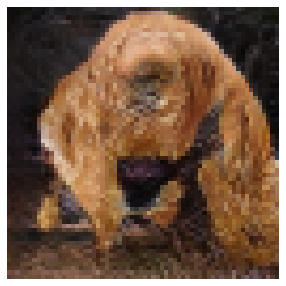

In [19]:
generate_test_image(dog_generator)

(16, 64, 64, 3)


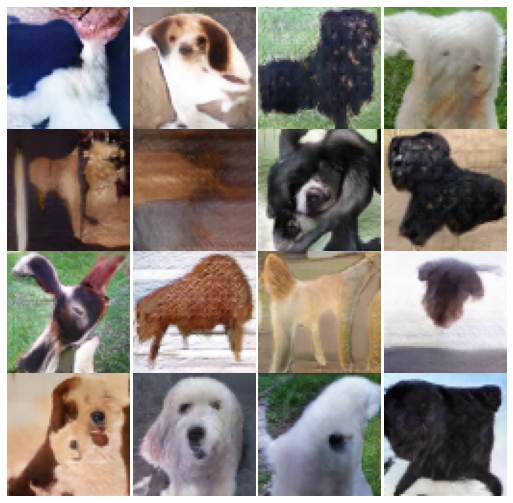

In [20]:
generate_and_show_images(dog_generator)